In [1]:
!pip install catboost

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRanker, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, label_binarize

In [3]:
data = pd.read_csv('intern_task.csv', sep=',')

**Препроцессинг и анализ входного датасета**

Для начала просто взглянем на выборку.

In [4]:
print(data.info())
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11949 entries, 0 to 11948
Columns: 146 entries, rank to feature_143
dtypes: float64(144), int64(2)
memory usage: 13.3 MB
None


rank  query_id  feature_0  feature_1  feature_2  feature_3  feature_4  \
0     0        10        1.0        0.0        1.0        3.0        3.0   
1     1        10        3.0        0.0        3.0        0.0        3.0   
2     0        10        3.0        0.0        2.0        0.0        3.0   
3     1        10        3.0        0.0        3.0        0.0        3.0   
4     2        10        3.0        0.0        3.0        1.0        3.0   

   feature_5  feature_6  feature_7  ...  feature_134  feature_135  \
0   0.333333        0.0   0.333333  ...          0.0     0.000000   
1   1.000000        0.0   1.000000  ...          0.0     0.000000   
2   1.000000        0.0   0.666667  ...          0.0     0.000000   
3   1.000000        0.0   1.000000  ...          0.0     0.000000   
4   1.000000        0.0   1.000000  ...        273.0    79.670665   

   feature_136  feature_137  feature_138  feature_139  feature_140  \
0     0.454545     0.890238     8.655534     1.000000     0.077778   
1     0.000000     0.773976    23.130514     0.000000     0.027826   
2     0.000000     0.918308    13.351339     0.000000     0.014925   
3     0.000000     0.975355    18.240926     0.000000     0.053140   
4     0.200000     0.990119    31.786048     0.333333     0.046512   

   feature_141  feature_142  feature_143  
0     0.002222          1.0     0.333333  
1     0.000430         44.0    14.666667  
2     0.000104         22.0     7.333333  
3     0.000255          8.0     2.666667  
4     0.000307         24.0     8.000000  

[5 rows x 146 columns]

Проверим есть ли незаполненные значения.

In [5]:
df = data[data.isna().any(axis=1)]
df

rank  query_id  feature_0  feature_1  feature_2  feature_3  feature_4  \
11948     1      1600        2.0        0.0        0.0        1.0        2.0   

       feature_5  feature_6  feature_7  ...  feature_134  feature_135  \
11948        1.0        0.0        0.0  ...          NaN          NaN   

       feature_136  feature_137  feature_138  feature_139  feature_140  \
11948          NaN          NaN          NaN          NaN          NaN   

       feature_141  feature_142  feature_143  
11948          NaN          NaN          NaN  

[1 rows x 146 columns]

Как видно, только в одной строке присутствуют значения NaN, поэтому просто отбросим найденную строку.

In [6]:
data = data.dropna()
data = data.drop_duplicates()

В какой-то момент feature_119 типа object, поэтому был написан следующий блок.

In [7]:
for col in data.columns:
  if data[col].dtype != np.int64 and data[col].dtype != np.float64:
    print(col)
data = data.astype({'feature_119': 'float64'})

In [8]:
data['feature_119'].unique()

array([-19.589214, -15.792263, -17.982153, ..., -12.356592, -10.435748,
       -10.725742])

In [9]:
#data.corr().style.background_gradient(cmap='coolwarm')

In [10]:
nan_features = ['feature_64', 'feature_65', 'feature_72', 'feature_100']
data = data.drop(nan_features, axis=1)
data.corr().style.background_gradient(cmap='coolwarm')

Проверив корреляцию между признаками, можно заметить, что некоторые признаки сильно линейно зависимы. Поэтому можно попробовать удалить некоторые фичи.

In [11]:
linearly_dependent_columns = set()
for i in range(2, len(data.columns)):
  for j in range(i + 1, len(data.columns)):
    if i not in linearly_dependent_columns and  \
    data.iloc[:, i].corr(data.iloc[:, j]) > 0.95:
      linearly_dependent_columns.add(j)
all_columns = set([i for i in range(len(data.columns))])
good_columns = all_columns - linearly_dependent_columns
data = data.iloc[:, list(good_columns)]

In [12]:
data.corr().style.background_gradient(cmap='coolwarm')

array([[<Axes: title={'center': 'rank'}>,
        <Axes: title={'center': 'query_id'}>,
        <Axes: title={'center': 'feature_0'}>,
        <Axes: title={'center': 'feature_1'}>,
        <Axes: title={'center': 'feature_2'}>,
        <Axes: title={'center': 'feature_3'}>,
        <Axes: title={'center': 'feature_5'}>,
        <Axes: title={'center': 'feature_6'}>,
        <Axes: title={'center': 'feature_7'}>,
        <Axes: title={'center': 'feature_8'}>],
       [<Axes: title={'center': 'feature_9'}>,
        <Axes: title={'center': 'feature_10'}>,
        <Axes: title={'center': 'feature_11'}>,
        <Axes: title={'center': 'feature_12'}>,
        <Axes: title={'center': 'feature_13'}>,
        <Axes: title={'center': 'feature_15'}>,
        <Axes: title={'center': 'feature_16'}>,
        <Axes: title={'center': 'feature_21'}>,
        <Axes: title={'center': 'feature_22'}>,
        <Axes: title={'center': 'feature_24'}>],
       [<Axes: title={'center': 'feature_25'}>,
       

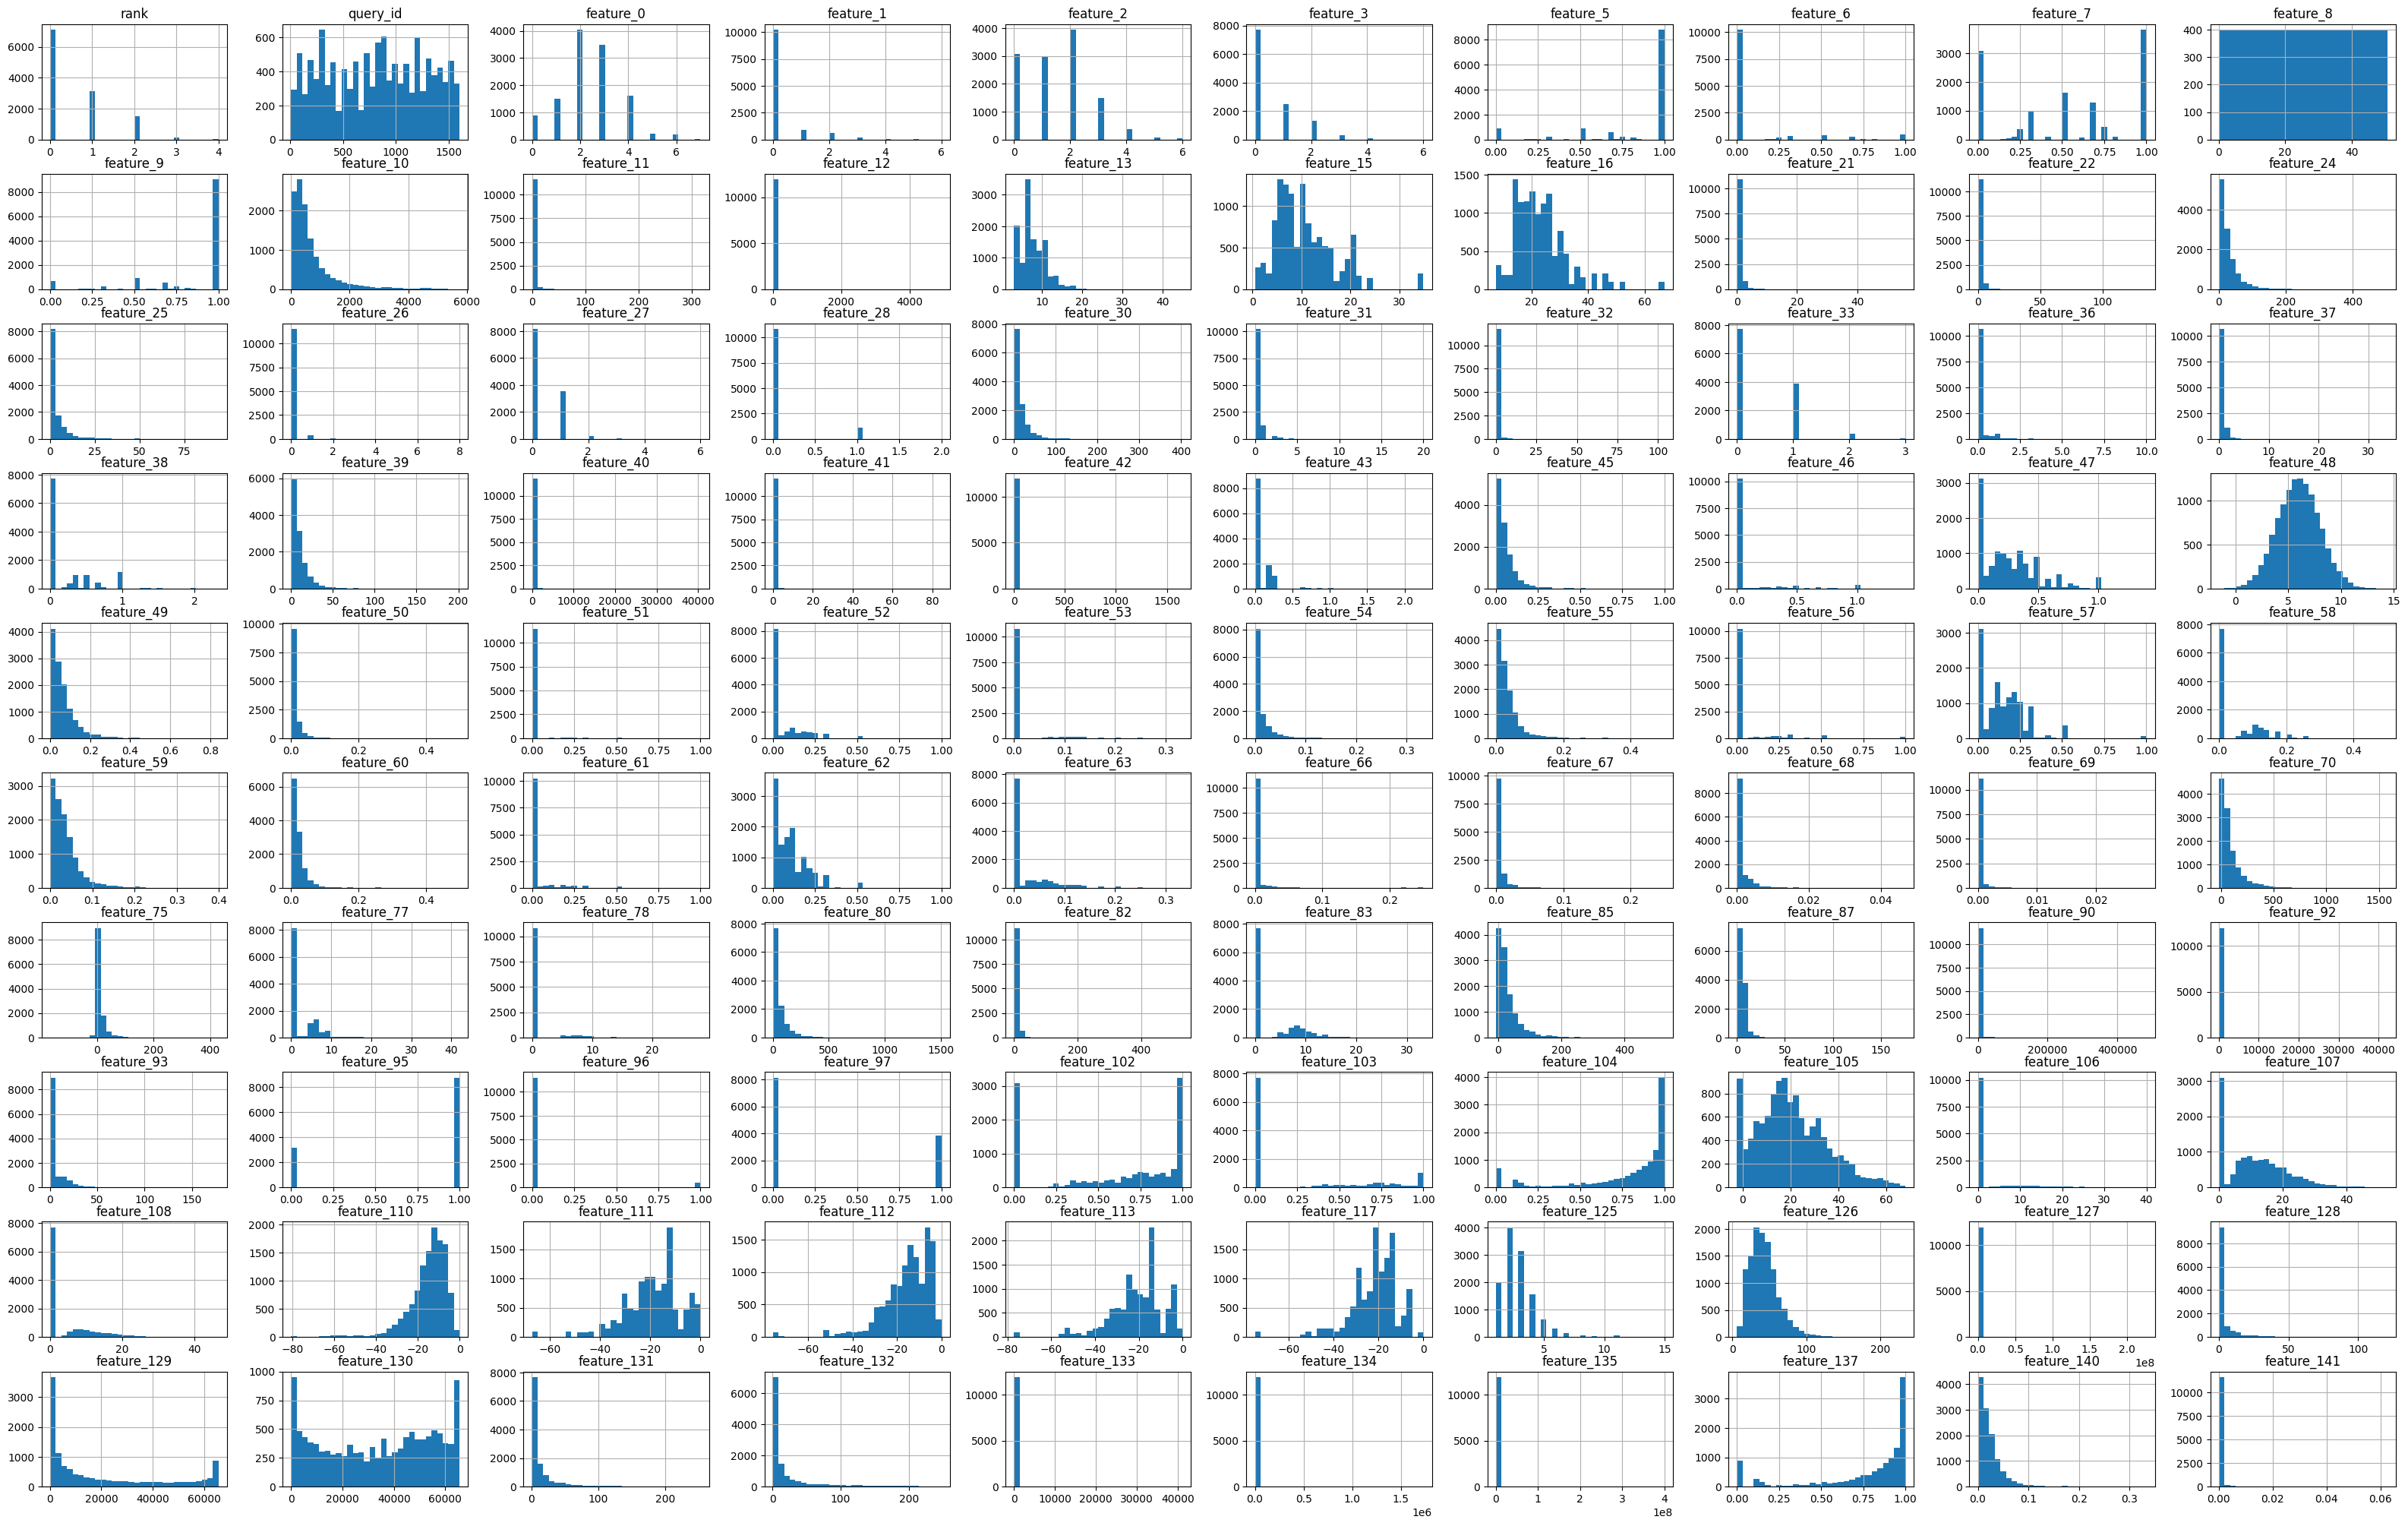

In [13]:
data.hist(bins=30, figsize=(40, 25))

На графиках видно, что данные распределены неоднородно, так что немного масштабируем данные.

In [14]:
scaler = StandardScaler()
scaler.fit(data.iloc[:, 2:])
data_norm = pd.DataFrame(scaler.transform(data.iloc[:, 2:]),
                         columns = data.columns[2:])

In [15]:
data_other = data.drop(columns = data.columns[2:])
data_new = pd.concat([data_norm, data_other], axis = 1)

**Обучение модели**

Разделим датасет на тренировочную, валидационную (так как используется бустинг есть вероятность переобучения) и тестовую выборку.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('rank', axis=1),
                                                    data['rank'],
                                                    train_size=0.7,
                                                    random_state=42)
df_train = pd.DataFrame.join(X_train, y_train)
df_test = pd.DataFrame.join(X_test, y_test, how='left')
df_test = df_test.sort_values(by='query_id')
df_train, df_val  = train_test_split(df_train, test_size = 0.2, random_state=42)
df_train = df_train.sort_values(by='query_id')
df_val = df_val.sort_values(by='query_id')

In [18]:
target = ['rank']
features = data.columns[2:]

train_pool = Pool(
    data = df_train[features],
    label = df_train[target],
    group_id = df_train['query_id'].tolist()
)

test_pool = Pool(
    data = df_test[features],
    label = df_test[target],
    group_id = df_test['query_id'].tolist()
)

val_pool = Pool(
    data = df_val[features],
    label = df_val[target],
    group_id = df_val['query_id'].tolist()
)

Дальше был немного fine-tuning и подбирались гиперпараметры.

In [19]:
default_parameters = {
    'iterations': 6000,
    'loss_function':'YetiRank',
    'verbose': True,
    'random_seed': 42,
    "od_type": "Iter",
    "od_wait" :15,
    "nan_mode" :"Min",
    "l2_leaf_reg":0.1,
    "rsm":0.4,
    "use_best_model":True,
    "custom_metric":'NDCG:top=5'
}

Для оценки модели будем использовать метрику NDCG@5

In [20]:
def ndcg_(m, df_test):
  cat_ndcg = []
  groups = np.unique(df_test['query_id'])

  for i, query in enumerate(groups):
    y = df_test[df_test['query_id'] == query][target]
    y = y.to_numpy().reshape(len(y),)
    if np.sum(y) == 0:
      continue
    result = m.predict(df_test[df_test['query_id'] == query][features])
    top_rank = np.argsort(result)[::-1]

    y = np.take(y, top_rank[:5])

    score_ndcg = ndcg_score([y], [result[top_rank[:5]]])
    cat_ndcg.append(score_ndcg)

  return np.mean(cat_ndcg)

In [21]:
eval_model = CatBoostRanker(**default_parameters)
eval_model.fit(train_pool, eval_set=val_pool, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6813240	best: 0.6813240 (0)	total: 75.7ms	remaining: 7m 33s
1:	test: 0.7477618	best: 0.7477618 (1)	total: 103ms	remaining: 5m 8s
2:	test: 0.7659005	best: 0.7659005 (2)	total: 130ms	remaining: 4m 19s
3:	test: 0.7538431	best: 0.7659005 (2)	total: 157ms	remaining: 3m 55s
4:	test: 0.7691383	best: 0.7691383 (4)	total: 182ms	remaining: 3m 38s
5:	test: 0.7635318	best: 0.7691383 (4)	total: 208ms	remaining: 3m 27s
6:	test: 0.7679817	best: 0.7691383 (4)	total: 236ms	remaining: 3m 21s
7:	test: 0.7674599	best: 0.7691383 (4)	total: 262ms	remaining: 3m 16s
8:	test: 0.7607818	best: 0.7691383 (4)	total: 292ms	remaining: 3m 14s
9:	test: 0.7608045	best: 0.7691383 (4)	total: 318ms	remaining: 3m 10s
10:	test: 0.7627383	best: 0.7691383 (4)	total: 344ms	remaining: 3m 7s
11:	test: 0.7607631	best: 0.7691383 (4)	total: 374ms	remaining: 3m 6s
12:	test: 0.7648792	best: 0.7691383 (4)	total: 406ms	remaining: 3m 7s
13:	test: 0.7688243	best: 0.7691383 (4)	total: 432ms	remaining: 3m 4s
14:	test: 0.7693940	

In [22]:
best_iteration=eval_model.get_best_iteration()
best_iteration

33

In [23]:
#eval_model.get_evals_result()

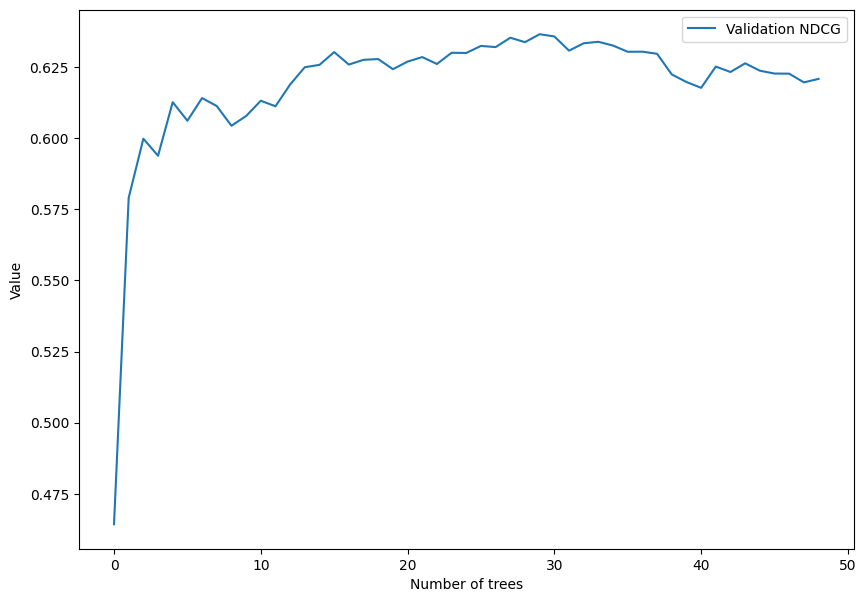

In [24]:
plt.figure(figsize=(10,7))
plt.plot(eval_model.evals_result_["validation"]['NDCG:top=5;type=Base'], label="Validation NDCG")
plt.xlabel("Number of trees")
plt.ylabel("Value")
plt.legend()


На гравике видно, что модели достаточно около 50 деревьев, для решения задачи.

NDCG = 0.7909375925271926

In [25]:
print(ndcg_(eval_model, df_test))

0.7909375925271926


Оценим модель и другой метрикой - MAP@5.

In [26]:
default_parameters["custom_metric"]='MAP:top=5'
map_model = CatBoostRanker(**default_parameters)
map_model.fit(train_pool, eval_set=val_pool, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6813240	best: 0.6813240 (0)	total: 75.4ms	remaining: 7m 32s
1:	test: 0.7477618	best: 0.7477618 (1)	total: 123ms	remaining: 6m 8s
2:	test: 0.7659005	best: 0.7659005 (2)	total: 179ms	remaining: 5m 57s
3:	test: 0.7538431	best: 0.7659005 (2)	total: 236ms	remaining: 5m 53s
4:	test: 0.7691383	best: 0.7691383 (4)	total: 293ms	remaining: 5m 50s
5:	test: 0.7635318	best: 0.7691383 (4)	total: 361ms	remaining: 6m
6:	test: 0.7679817	best: 0.7691383 (4)	total: 419ms	remaining: 5m 58s
7:	test: 0.7674599	best: 0.7691383 (4)	total: 467ms	remaining: 5m 49s
8:	test: 0.7607818	best: 0.7691383 (4)	total: 517ms	remaining: 5m 44s
9:	test: 0.7608045	best: 0.7691383 (4)	total: 571ms	remaining: 5m 42s
10:	test: 0.7627383	best: 0.7691383 (4)	total: 626ms	remaining: 5m 40s
11:	test: 0.7607631	best: 0.7691383 (4)	total: 679ms	remaining: 5m 39s
12:	test: 0.7648792	best: 0.7691383 (4)	total: 763ms	remaining: 5m 51s
13:	test: 0.7688243	best: 0.7691383 (4)	total: 854ms	remaining: 6m 5s
14:	test: 0.7693940	b

In [27]:
#map_model.get_evals_result()

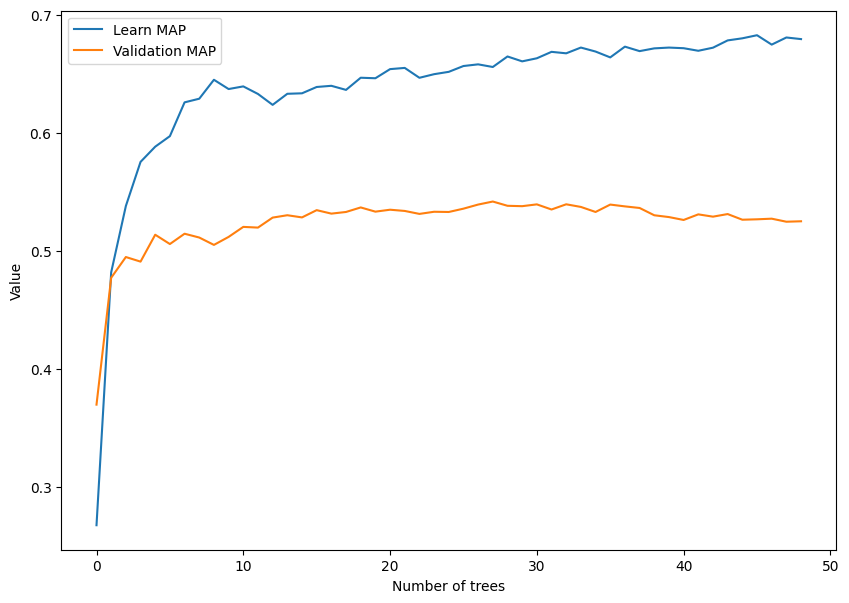

In [28]:
plt.figure(figsize=(10,7))
plt.plot(map_model.evals_result_["learn"]['MAP:top=5'], label="Learn MAP")
plt.plot(map_model.evals_result_["validation"]['MAP:top=5'], label="Validation MAP")
plt.xlabel("Number of trees")
plt.ylabel("Value")
plt.legend()

In [29]:
!pip install tensorflow_ranking

In [30]:
import tensorflow_ranking as tfr

In [31]:
y_true = []
y_pred = []
groups = np.unique(df_test['query_id'])

for i, query in enumerate(groups):
  y = df_test[df_test['query_id'] == query][target]
  y = y.to_numpy().reshape(len(y),)
  if np.sum(y) == 0:
    continue
  result = map_model.predict(df_test[df_test['query_id'] == query][features])
  top_rank = np.argsort(result)[::-1]

  y = np.take(y, top_rank[:5])
  y_true.append(y)
  y_pred.append(result[top_rank[:5]])

In [32]:
map_metric = tfr.keras.metrics.MeanAveragePrecisionMetric(topn=5)
map_metric(y_true, y_pred).numpy()

0.7768964

Значение метрики MAP = 0.7768964